# Sentiment Analysis of FOMC Statements

Analyse statement by Loughran and McDonald dictionary

In [1]:
%config InlineBackend.figure_format='retina'
import logging
from ekorpkit import eKonf

logging.basicConfig(level=logging.INFO)
print("version:", eKonf.__version__)
print("is notebook?", eKonf.is_notebook())
print("is colab?", eKonf.is_colab())
print("evironment varialbles:")
eKonf.print(eKonf.env().dict())

INFO:ekorpkit.base:IPython version: (6, 9, 0), client: jupyter_client
INFO:ekorpkit.base:Google Colab not detected.


version: 0.1.33+23.gbb9860e.dirty
is notebook? True
is colab? False
evironment varialbles:
{'EKORPKIT_CONFIG_DIR': '/workspace/projects/ekorpkit-book/config',
 'EKORPKIT_DATA_DIR': None,
 'EKORPKIT_PROJECT': 'ekorpkit-book',
 'EKORPKIT_WORKSPACE_ROOT': '/workspace',
 'NUM_WORKERS': 230}


In [2]:
start_year = 2000
eKonf.env().FRED_API_KEY

pydantic.types.SecretStr

## Load FOMC Corpus

In [3]:
cfg = eKonf.compose("corpus")
cfg.name = "fomc"
cfg.path.cache.uri = (
    "https://github.com/entelecheia/ekorpkit-book/raw/main/data/fomc.zip"
)
cfg.data_dir = cfg.path.cached_path
cfg.auto.merge = True
fomc = eKonf.instantiate(cfg)
print(fomc)

INFO:cached_path:cache of https://github.com/entelecheia/ekorpkit-book/raw/main/data/fomc.zip is up-to-date
INFO:ekorpkit.io.cached_path:cached path: /workspace/.cache/cached_path/bfb02a9385e069aa04bc8073f61e48b26d2b93943100d8a6851436fac63d2c6d.14993cbcce092b4473939a6ed9e8246dfeb3d500c53c11c6279991e9a0eba476-extracted
INFO:cached_path:cache of https://github.com/entelecheia/ekorpkit-book/raw/main/data/fomc.zip is up-to-date
INFO:ekorpkit.io.cached_path:cached path: /workspace/.cache/cached_path/bfb02a9385e069aa04bc8073f61e48b26d2b93943100d8a6851436fac63d2c6d.14993cbcce092b4473939a6ed9e8246dfeb3d500c53c11c6279991e9a0eba476-extracted
INFO:cached_path:cache of https://github.com/entelecheia/ekorpkit-book/raw/main/data/fomc.zip is up-to-date
INFO:ekorpkit.io.cached_path:cached path: /workspace/.cache/cached_path/bfb02a9385e069aa04bc8073f61e48b26d2b93943100d8a6851436fac63d2c6d.14993cbcce092b4473939a6ed9e8246dfeb3d500c53c11c6279991e9a0eba476-extracted
INFO:ekorpkit.datasets.base:Loaded info 

Corpus : fomc


In [4]:
print(fomc.data.content_type.unique())
fomc.data.head()

INFO:ekorpkit.io.file:Concatenating 1 dataframes
INFO:ekorpkit.io.file:Concatenating 1 dataframes


['fomc_minutes' 'fomc_statement' 'fomc_speech' 'fomc_beigebook'
 'fomc_testimony' 'fomc_press_conf' 'fomc_meeting_script']


,id,text,split,timestamp,content_type,date,speaker,title
0,0,A meeting of the Federal Open Market Committee...,train,1993-02-03,fomc_minutes,1993-02-03,Alan Greenspan,FOMC Meeting Minutes
1,1,A meeting of the Federal Open Market Committee...,train,1993-03-23,fomc_minutes,1993-03-23,Alan Greenspan,FOMC Meeting Minutes
2,2,A meeting of the Federal Open Market Committee...,train,1993-05-18,fomc_minutes,1993-05-18,Alan Greenspan,FOMC Meeting Minutes
3,3,A meeting of the Federal Open Market Committee...,train,1993-07-07,fomc_minutes,1993-07-07,Alan Greenspan,FOMC Meeting Minutes
4,4,A meeting of the Federal Open Market Committee...,train,1993-08-17,fomc_minutes,1993-08-17,Alan Greenspan,FOMC Meeting Minutes


In [5]:
fomc_statements = fomc.data[fomc.data.content_type == "fomc_statement"]
fomc_statements = fomc_statements[fomc_statements.timestamp.dt.year >= start_year]
fomc_statements.set_index("timestamp", inplace=True)
fomc_statements.head()

INFO:ekorpkit.io.file:Concatenating 1 dataframes
INFO:ekorpkit.io.file:Concatenating 1 dataframes


,id,text,split,content_type,date,speaker,title
timestamp,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,train,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement
2000-03-21,251,For immediate release The Federal Open Market ...,train,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement
2000-05-16,252,For immediate release The Federal Open Market ...,train,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement
2000-06-28,253,For immediate release The Federal Open Market ...,train,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement
2000-08-22,254,For immediate release The Federal Open Market ...,train,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement


## Predict setniments with the LM sentiment analyser

In [6]:
model_cfg = eKonf.compose('model/sentiment=lm')
# model_cfg.verbose = 10
model_cfg.num_workers = 10
lmsa = eKonf.instantiate(model_cfg)

INFO:ekorpkit.preprocessors.tokenizer:instantiating ekorpkit.preprocessors.stopwords.Stopwords...
INFO:ekorpkit.base:Calling load_candidates
INFO:ekorpkit.io.file:Processing [1] files from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading data from /workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet
INFO:ekorpkit.models.ngram.ngram:loaded 58142 candidates


In [7]:
article = fomc_statements.text[10]
lmsa.predict_article(article)

{'num_examples': 9,
 'polarity_mean': -0.5005290181607607,
 'polarity_median': -0.7142856122449125,
 'polarity_diffusion': -0.7777777777777778,
 'positive': 0.0,
 'negative': 7.0,
 'num_tokens_sum': 1458.0,
 'num_tokens_mean': 162.0,
 'num_tokens_median': 199.0,
 'polarity_mean_label': 'negative',
 'polarity_median_label': 'negative',
 'polarity_diffusion_label': 'negative',
 'uncertainty_mean': 0.038049539402185834,
 'uncertainty_median': 0.04365179365079365}

In [8]:
model_cfg = eKonf.compose('model/sentiment=lm')

cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.model = model_cfg
# cfg._predict_ = model_cfg._predict_
cfg.output_dir = "../data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'
cfg.num_workers = 10
cfg.verbose = True
# eKonf.print(cfg)
fomc_sentiments = eKonf.pipe(fomc_statements, cfg)
fomc_sentiments.head()

INFO:ekorpkit.base:Applying pipe: functools.partial(<function predict at 0x7fbc775590d0>)
INFO:ekorpkit.base:instantiating ekorpkit.models.sentiment.base.SentimentAnalyser...
INFO:ekorpkit.preprocessors.tokenizer:instantiating ekorpkit.preprocessors.stopwords.Stopwords...
INFO:ekorpkit.base:Calling load_candidates
INFO:ekorpkit.io.file:Processing [1] files from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['/workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet']
INFO:ekorpkit.io.file:Loading data from /workspace/projects/ekorpkit/ekorpkit/resources/lexicons/LM.parquet
INFO:ekorpkit.models.ngram.ngram:loaded 58142 candidates
INFO:ekorpkit.models.sentiment.base:Predicting sentiments of the column [text] using predict_article
INFO:ekorpkit.base:Using batcher with minibatch size: 19
INFO:ekorpkit.utils.batch.batcher: backend: joblib  minibatch_size: 19  procs: 10  input_split: False  merge_output: True

,id,text,split,content_type,date,speaker,title,num_examples,polarity_mean,polarity_median,...,positive,negative,num_tokens_sum,num_tokens_mean,num_tokens_median,polarity_mean_label,polarity_median_label,polarity_diffusion_label,uncertainty_mean,uncertainty_median
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,train,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,8,-0.37500,-0.600000,...,0.0,5.0,1199.0,149.875,184.5,negative,negative,negative,0.015972,0.019095
2000-03-21,251,For immediate release The Federal Open Market ...,train,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,8,-0.37500,-0.600000,...,0.0,5.0,1238.0,154.750,191.5,negative,negative,negative,0.015476,0.018478
2000-05-16,252,For immediate release The Federal Open Market ...,train,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,8,-0.15625,-0.250000,...,0.0,5.0,1146.0,143.250,179.5,negative,negative,negative,0.024587,0.019705
2000-06-28,253,For immediate release The Federal Open Market ...,train,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,8,0.00000,0.000000,...,0.0,0.0,994.0,124.250,158.5,neutral,neutral,neutral,0.046369,0.045978
2000-08-22,254,For immediate release The Federal Open Market ...,train,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,8,-0.25000,-0.333333,...,0.0,6.0,989.0,123.625,158.5,negative,negative,negative,0.034581,0.028737


In [9]:
cfg = eKonf.compose('pipeline/predict')
cfg.name = 'fomc_sentiments'
cfg.output_dir = "../data/predict"
cfg.output_file = f'{cfg.name}-lm.parquet'

fomc_sentiments = eKonf.load_data(cfg.output_file, cfg.output_dir)
fomc_sentiments.head()

INFO:ekorpkit.io.file:Processing [1] files from ['fomc_sentiments-lm.parquet']
INFO:ekorpkit.io.file:Loading 1 dataframes from ['../data/predict/fomc_sentiments-lm.parquet']
INFO:ekorpkit.io.file:Loading data from ../data/predict/fomc_sentiments-lm.parquet


,id,text,split,content_type,date,speaker,title,num_examples,polarity_mean,polarity_median,...,positive,negative,num_tokens_sum,num_tokens_mean,num_tokens_median,polarity_mean_label,polarity_median_label,polarity_diffusion_label,uncertainty_mean,uncertainty_median
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,train,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,8,-0.37500,-0.600000,...,0.0,5.0,1199.0,149.875,184.5,negative,negative,negative,0.015972,0.019095
2000-03-21,251,For immediate release The Federal Open Market ...,train,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,8,-0.37500,-0.600000,...,0.0,5.0,1238.0,154.750,191.5,negative,negative,negative,0.015476,0.018478
2000-05-16,252,For immediate release The Federal Open Market ...,train,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,8,-0.15625,-0.250000,...,0.0,5.0,1146.0,143.250,179.5,negative,negative,negative,0.024587,0.019705
2000-06-28,253,For immediate release The Federal Open Market ...,train,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,8,0.00000,0.000000,...,0.0,0.0,994.0,124.250,158.5,neutral,neutral,neutral,0.046369,0.045978
2000-08-22,254,For immediate release The Federal Open Market ...,train,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,8,-0.25000,-0.333333,...,0.0,6.0,989.0,123.625,158.5,negative,negative,negative,0.034581,0.028737


## Plot the sentiment scores

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


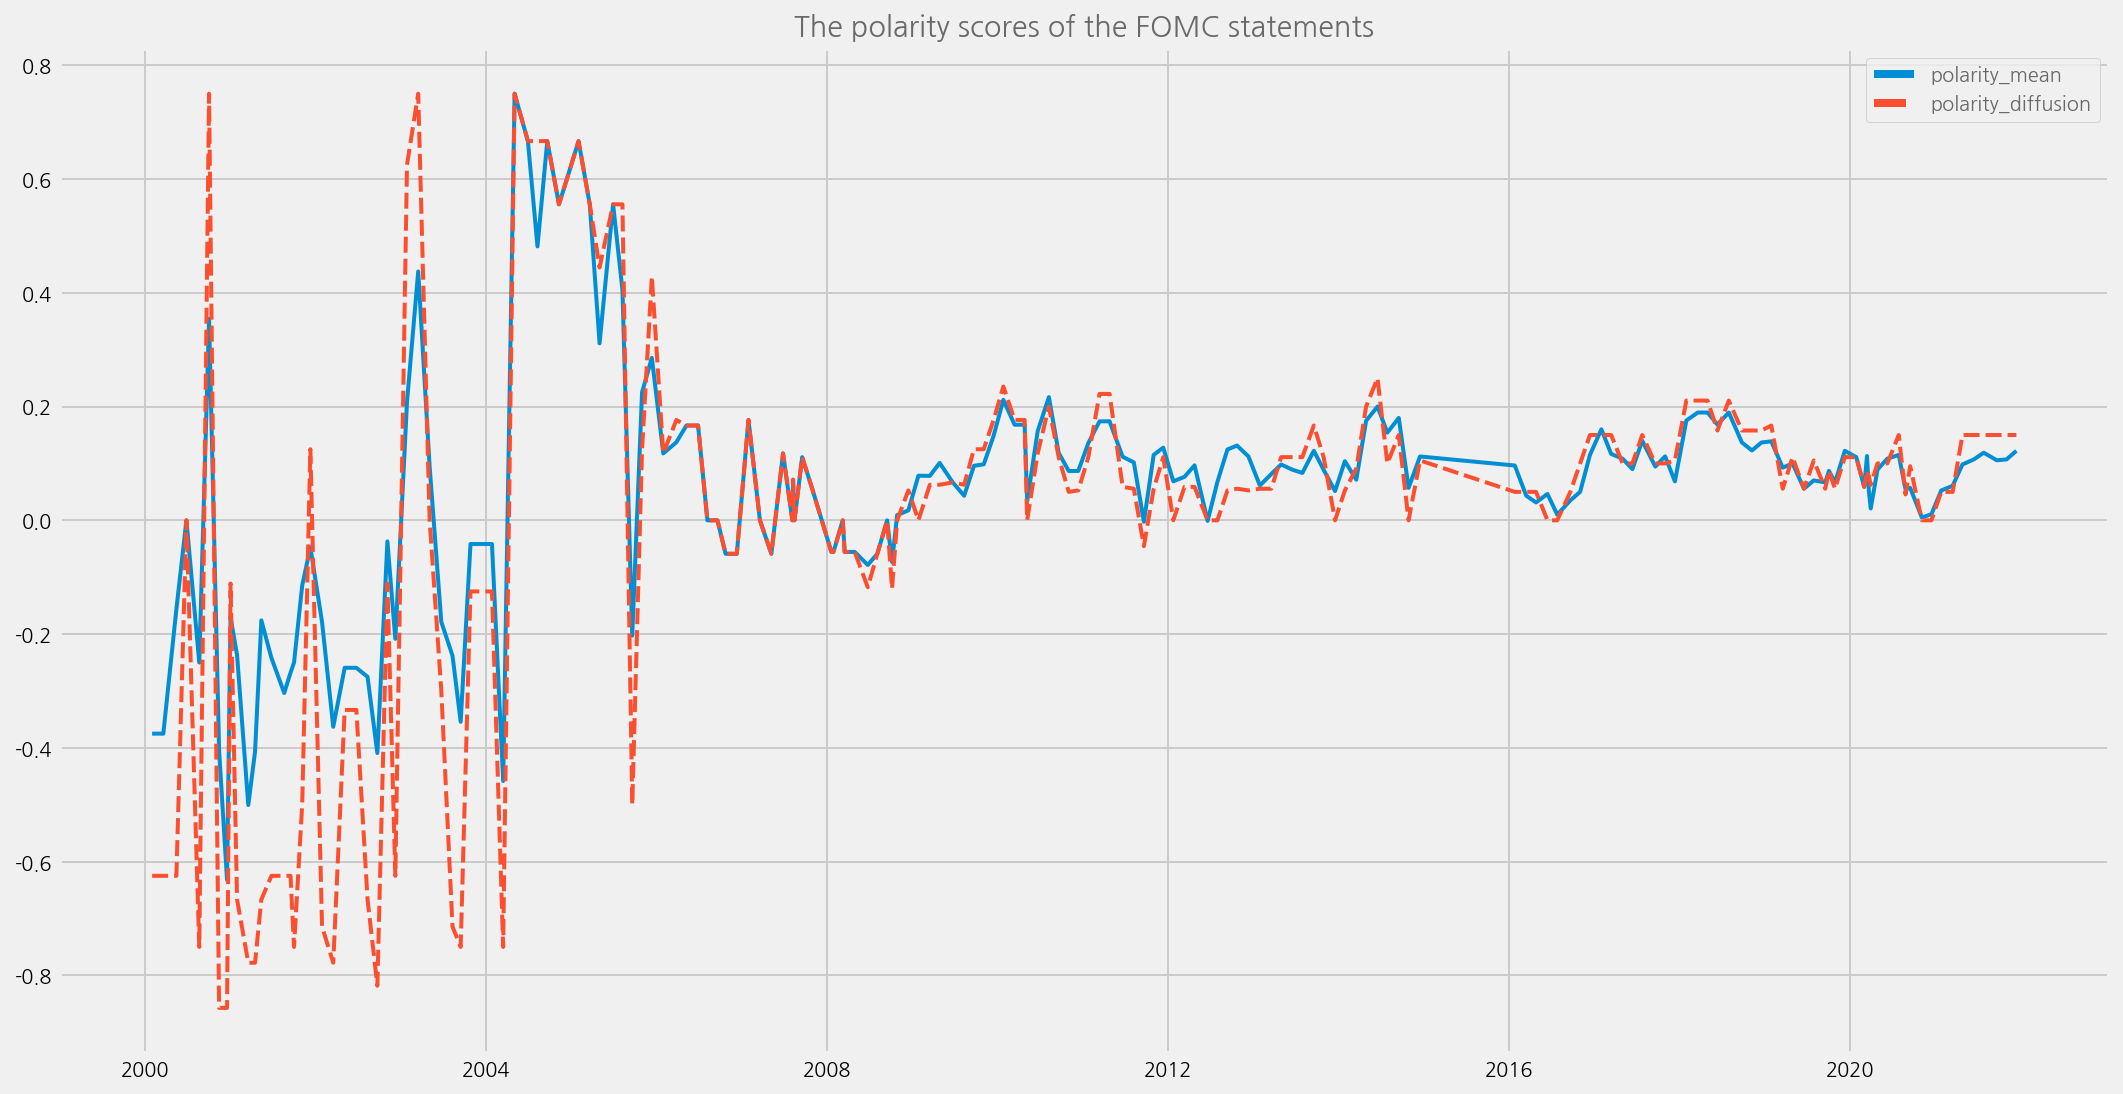

In [10]:
cfg = eKonf.compose('visualize/plot=lineplot')
# cfg.plot.x = 'timestamp'
cfg.plot.y = ['polarity_mean', 'polarity_diffusion']
cfg.figure.figsize = '(15, 8)'
cfg.ax.title = 'The polarity scores of the FOMC statements'
eKonf.instantiate(cfg, data=fomc_sentiments)

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'red', 'x': 'timestamp', 'y': 'num_tokens_sum', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.plot:Creating secondary axis to axis[0]
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'green', 'x': 'timestamp', 'y': 'num_examples', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 

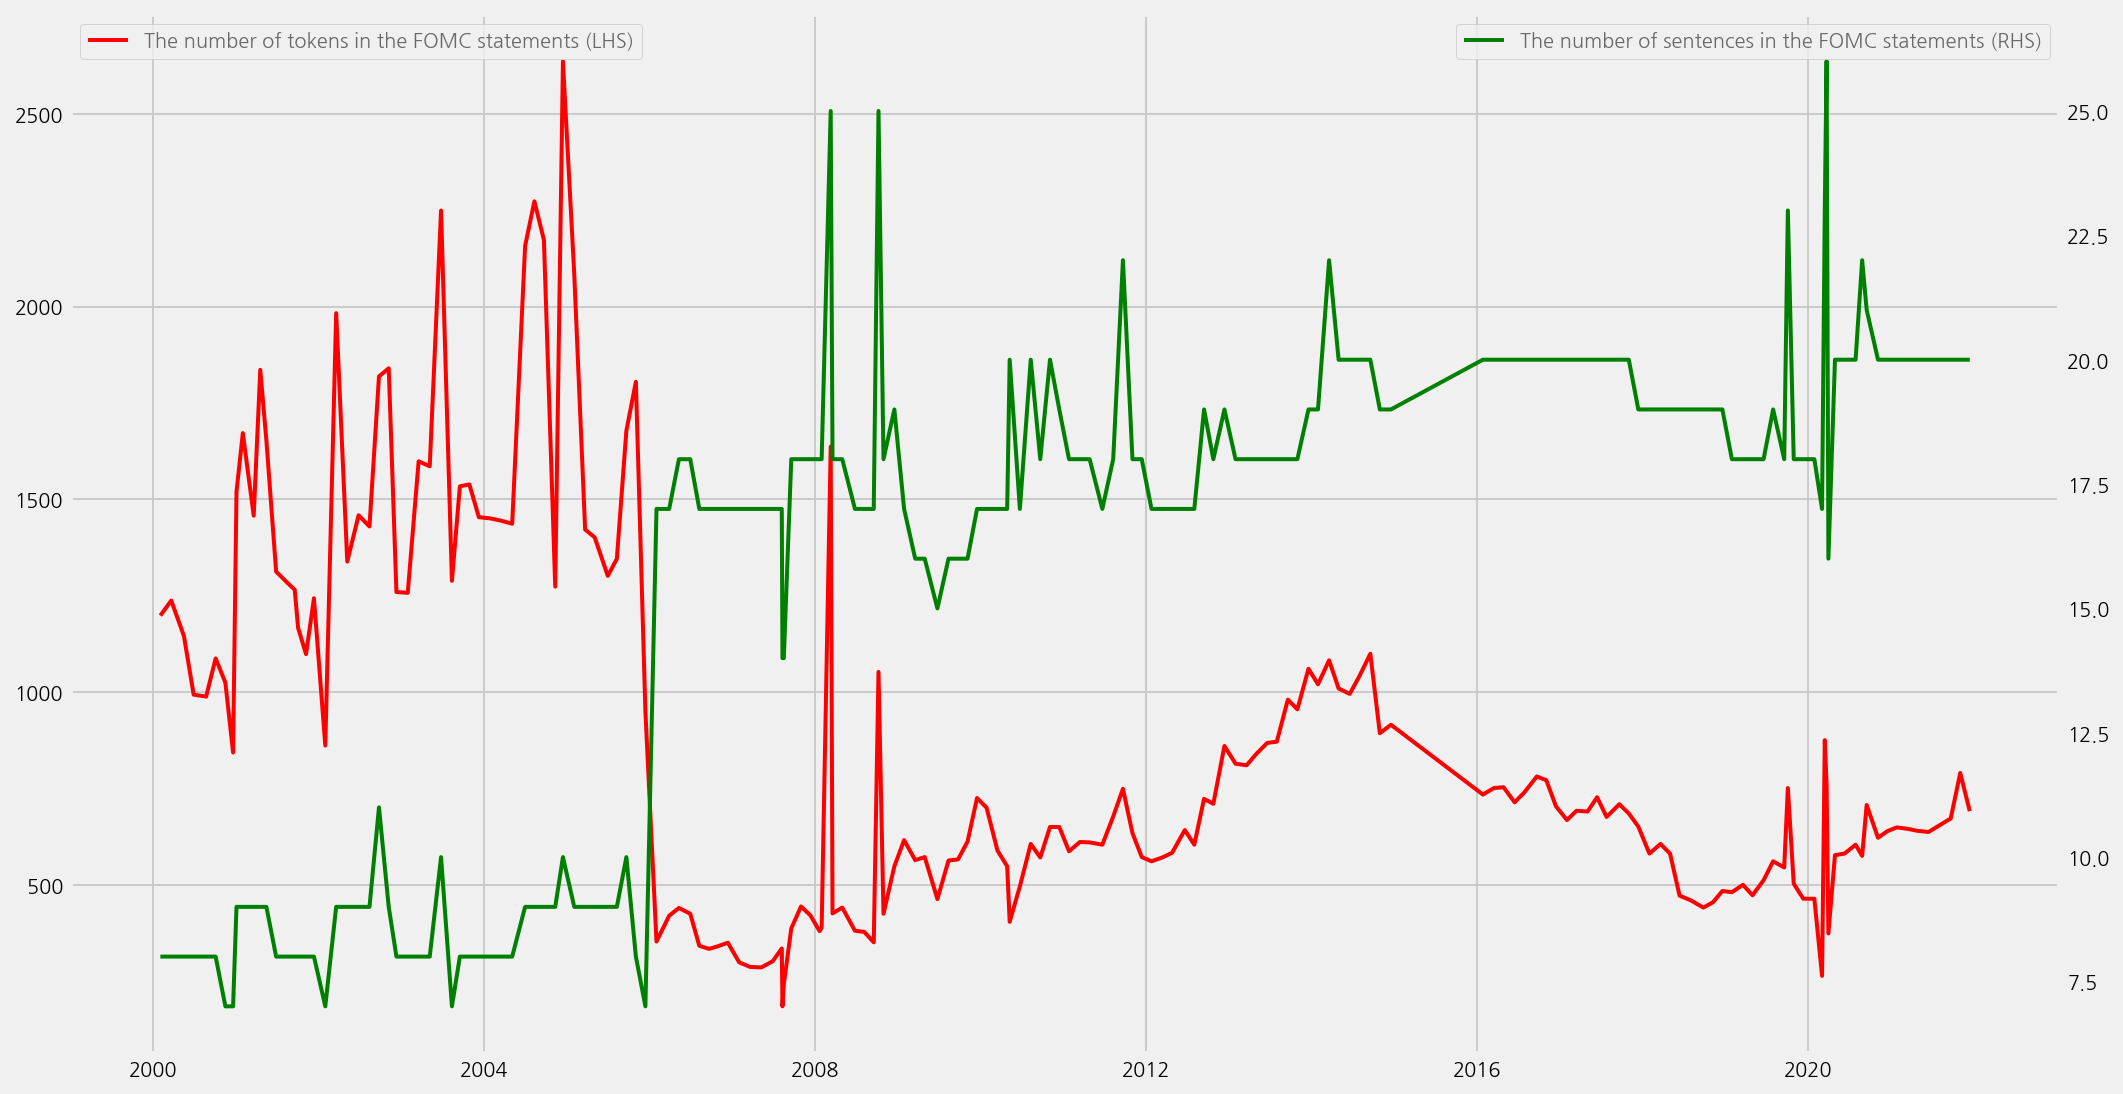

In [11]:
cfg = eKonf.compose('visualize/plot=lineplot')
cfg.figure.figsize = (15, 8)
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "num_tokens_sum"
cfg.plots[0].rcParams = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "num_examples"
cfg.plots[1].rcParams = dict(linewidth=1.5, color="green")
cfg.plots[1].secondary_y = True
cfg.ax.legend = dict(
    labels=[
        "The number of tokens in the FOMC statements (LHS)",
    ],
    loc=2,
)
ax2 = cfg.ax.copy()
ax2.grid = False
ax2.secondary_y = True
ax2.legend = dict(
    labels=["The number of sentences in the FOMC statements (RHS)"],
    loc=1,
)
cfg.axes.append(ax2)

eKonf.instantiate(cfg, data=fomc_sentiments)

INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2.5, 'palette': ['b', 'r'], 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


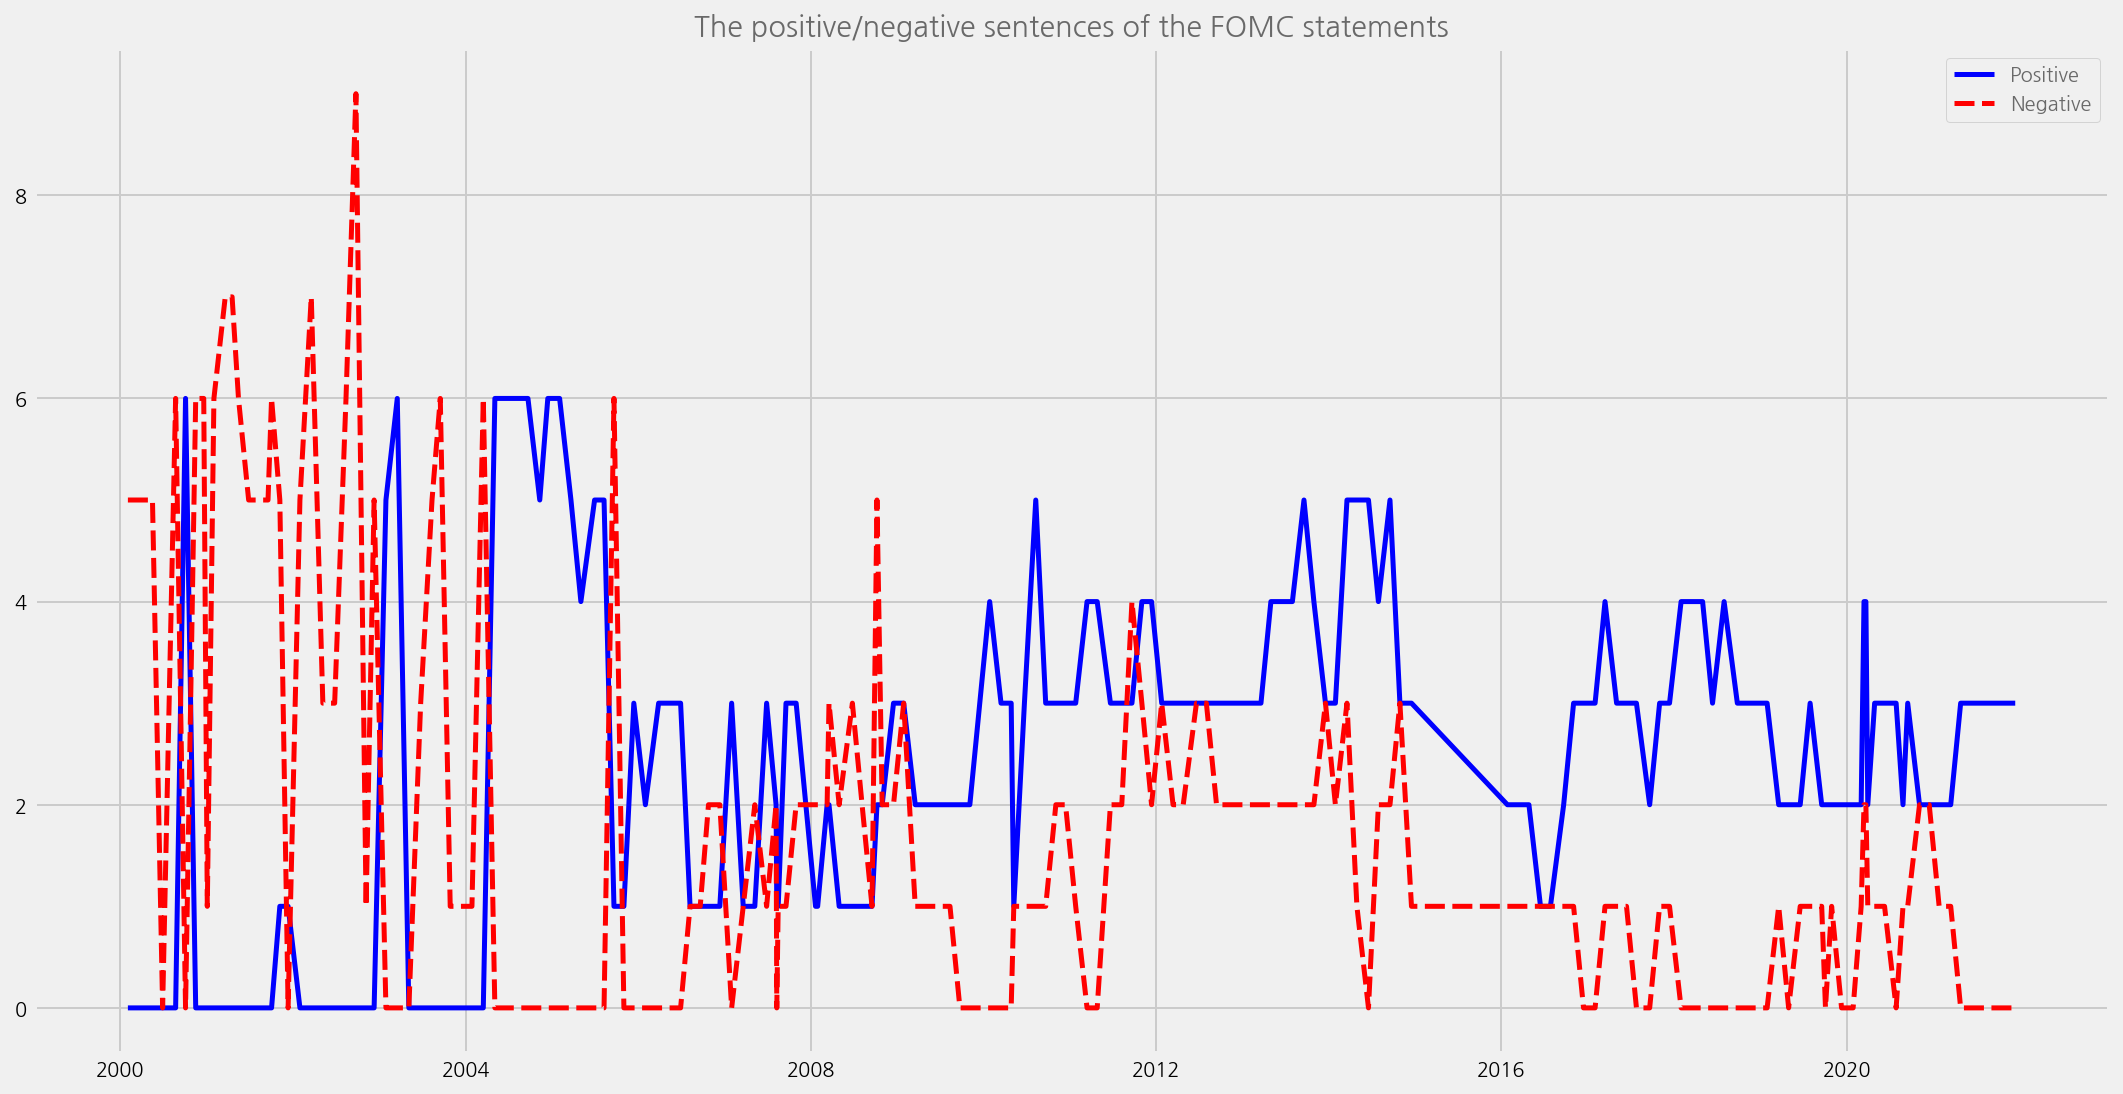

In [12]:
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.plot.y = ["positive", "negative"]
cfg.plot.palette = ["b", "r"]
cfg.plot.linewidth = 2.5
cfg.figure.figsize = (15, 8)
cfg.ax.title = "The positive/negative sentences of the FOMC statements"
cfg.ax.legend.labels = ["Positive", "Negative"]
eKonf.instantiate(cfg, data=fomc_sentiments)

INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/StackPlot.png


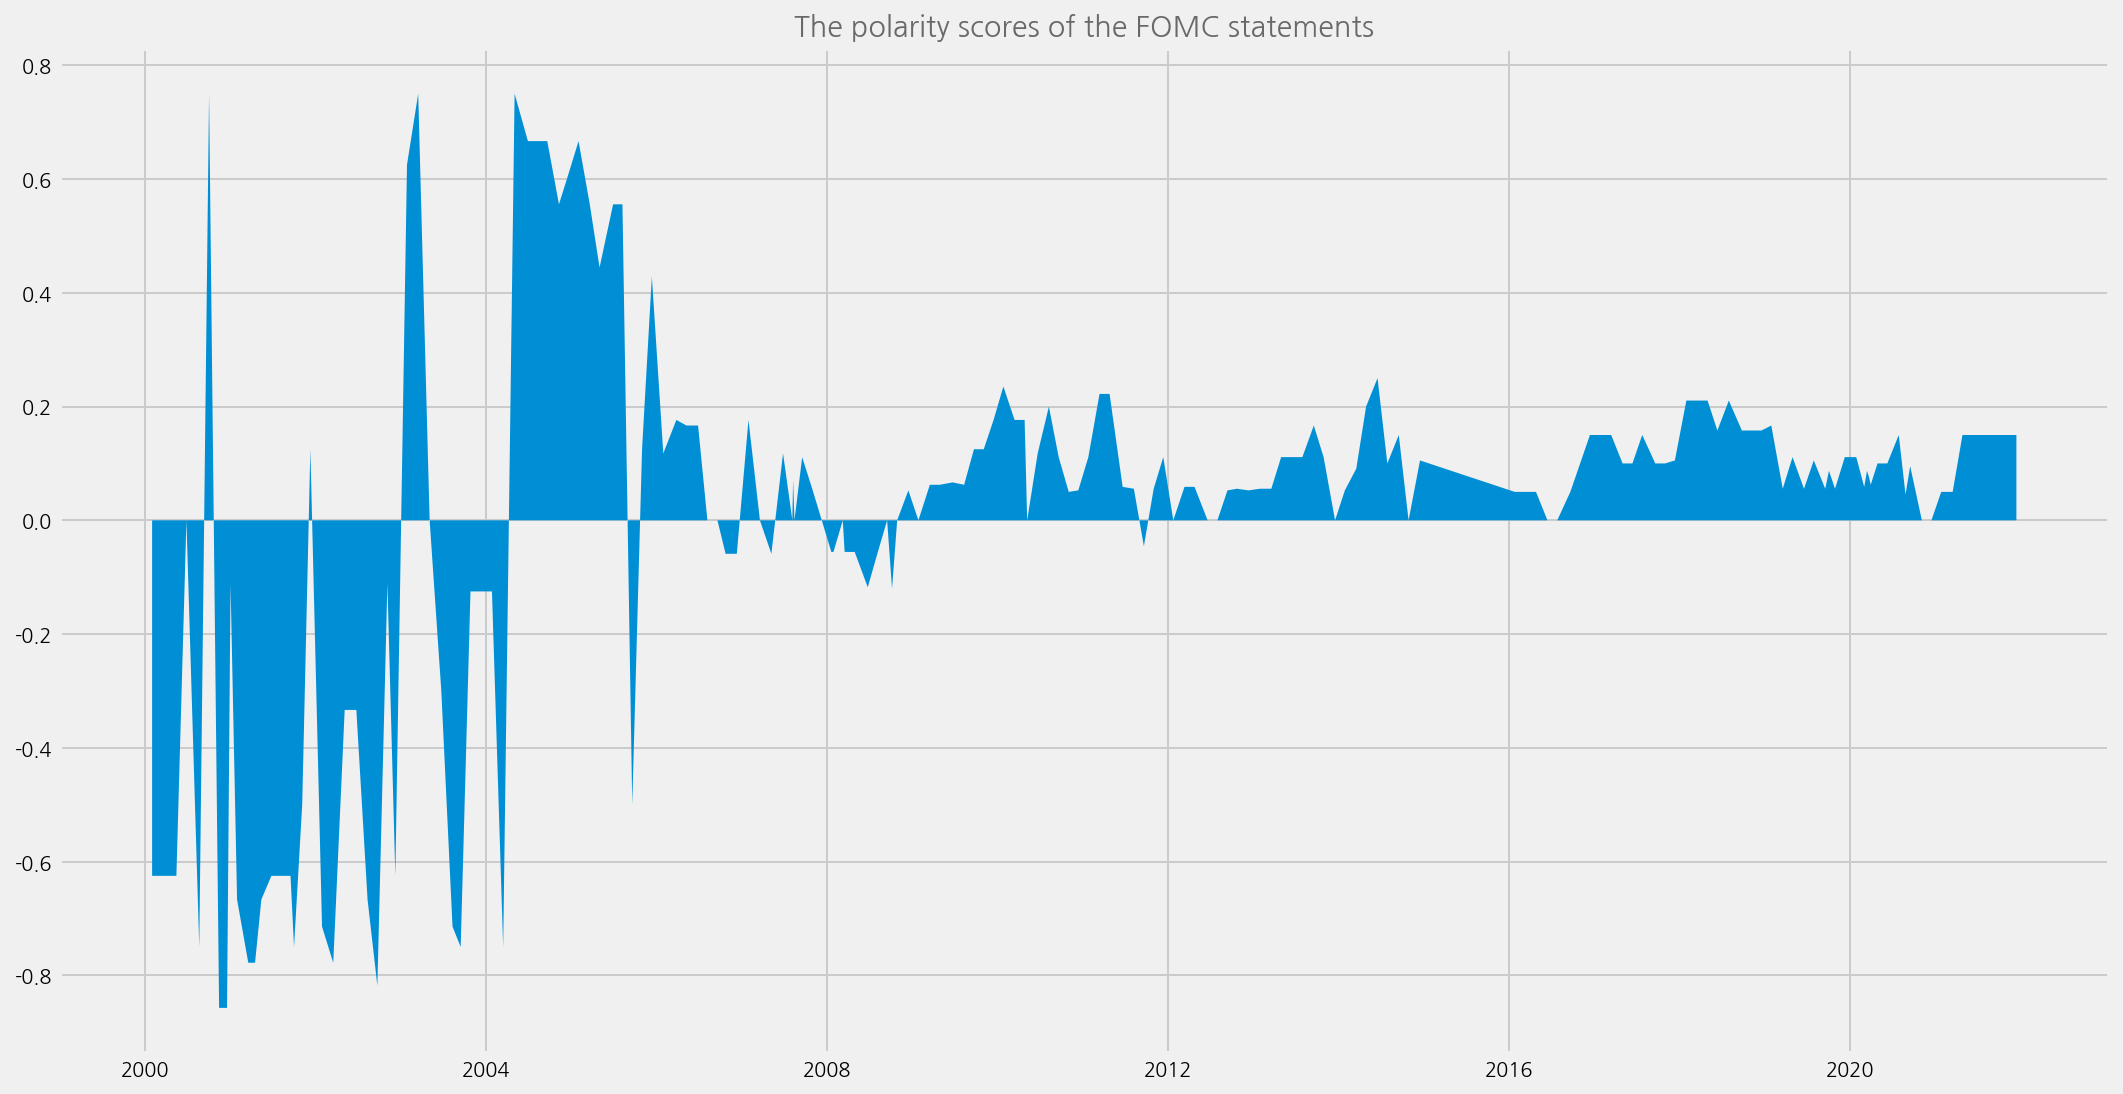

In [14]:
cfg = eKonf.compose('visualize/plot=stackplot')
cfg.plot.y = ['polarity_diffusion']
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'The polarity scores of the FOMC statements'
cfg.ax.xtickmajorformatterfunc = "mdates.DateFormatter('%Y')"
eKonf.instantiate(cfg, data=fomc_sentiments)


### Merge with fed rate data

INFO:ekorpkit.base:Applying pipe: functools.partial(<function eval_columns at 0x7fbc77552790>)
INFO:ekorpkit.base:Applying pipe: functools.partial(<function eval_columns at 0x7fbc77552790>)
INFO:ekorpkit.io.file:Saving dataframe to /workspace/.tmp/fred/DFEDTAR.parquet
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'date', 'y': 'DFEDTAR', 'linewidth': 2, 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figure to /workspace/projects/ekorpkit-book/outputs/figs/LinePlot.png


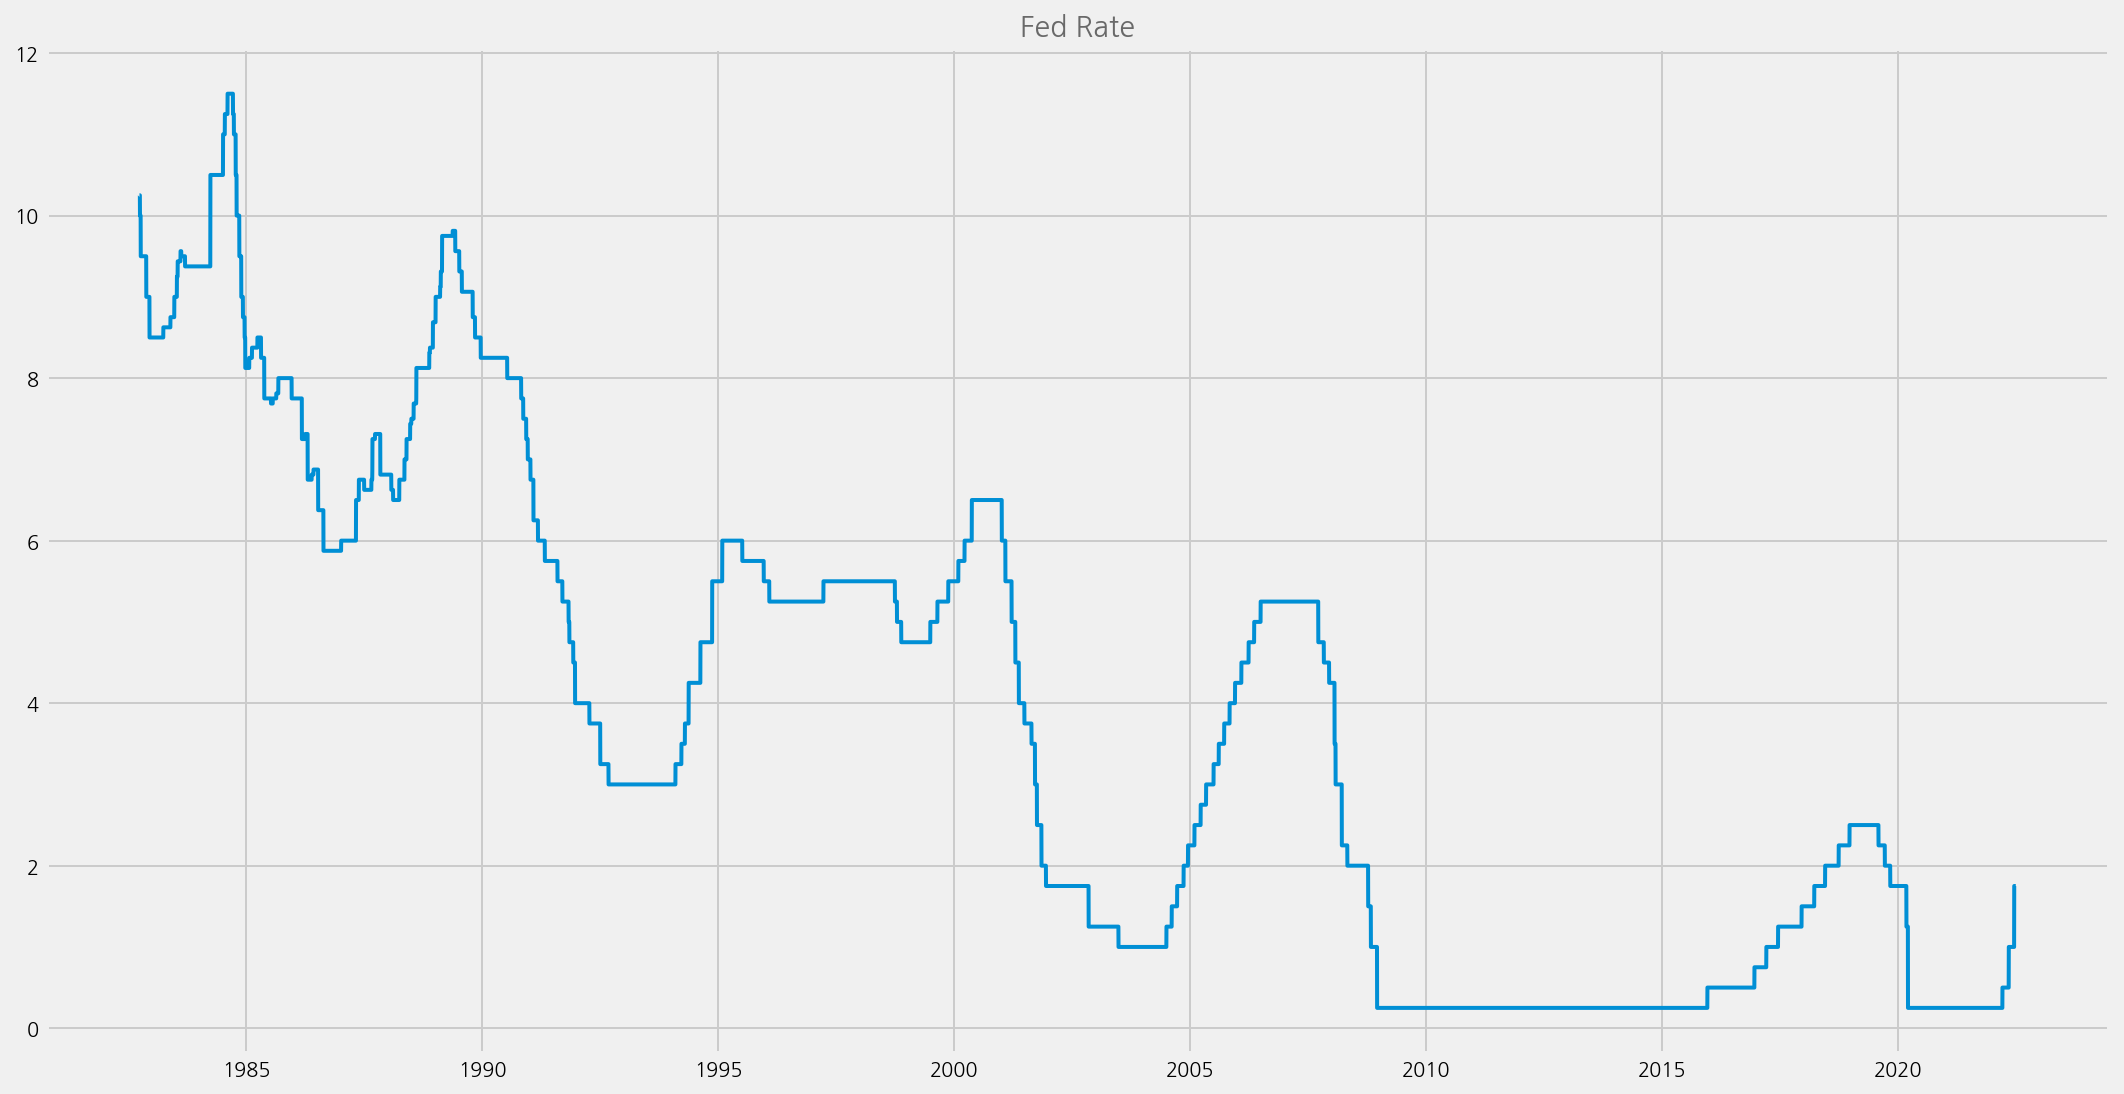

In [15]:
cfg = eKonf.compose("io/fetcher=quandl")
cfg.series_name = "DFEDTAR"
cfg.series_id = ["DFEDTAR", "DFEDTARU"]
cfg.force_download = True
quandl = eKonf.instantiate(cfg)

fedrates = quandl.data.copy()

cfg = eKonf.compose('visualize/plot=lineplot')
cfg.plot.x = 'date'
cfg.plot.y = 'DFEDTAR'
cfg.figure.figsize = (15, 8)
cfg.ax.title = 'Fed Rate'
eKonf.instantiate(cfg, data=fedrates)

In [16]:
fomc_sentiments = fomc_sentiments.merge(fedrates, left_index=True, right_index=True)
fomc_sentiments.index.name = 'timestamp'
fomc_sentiments.head()

,id,text,split,content_type,date,speaker,title,num_examples,polarity_mean,polarity_median,...,num_tokens_sum,num_tokens_mean,num_tokens_median,polarity_mean_label,polarity_median_label,polarity_diffusion_label,uncertainty_mean,uncertainty_median,DFEDTAR,series_id
timestamp,,,,,,,,,,,,,,,,,,,,,
2000-02-02,250,For immediate release The Federal Open Market ...,train,fomc_statement,2000-02-02,Alan Greenspan,FOMC Statement,8,-0.37500,-0.600000,...,1199.0,149.875,184.5,negative,negative,negative,0.015972,0.019095,5.75,DFEDTAR
2000-03-21,251,For immediate release The Federal Open Market ...,train,fomc_statement,2000-03-21,Alan Greenspan,FOMC Statement,8,-0.37500,-0.600000,...,1238.0,154.750,191.5,negative,negative,negative,0.015476,0.018478,6.00,DFEDTAR
2000-05-16,252,For immediate release The Federal Open Market ...,train,fomc_statement,2000-05-16,Alan Greenspan,FOMC Statement,8,-0.15625,-0.250000,...,1146.0,143.250,179.5,negative,negative,negative,0.024587,0.019705,6.50,DFEDTAR
2000-06-28,253,For immediate release The Federal Open Market ...,train,fomc_statement,2000-06-28,Alan Greenspan,FOMC Statement,8,0.00000,0.000000,...,994.0,124.250,158.5,neutral,neutral,neutral,0.046369,0.045978,6.50,DFEDTAR
2000-08-22,254,For immediate release The Federal Open Market ...,train,fomc_statement,2000-08-22,Alan Greenspan,FOMC Statement,8,-0.25000,-0.333333,...,989.0,123.625,158.5,negative,negative,negative,0.034581,0.028737,6.50,DFEDTAR


### Plot the results and compare to the economical uncertainty / systemic risk periods

In [17]:
cfg = eKonf.compose("io/fetcher/fomc")
cfg.output_dir = "../data/fomc"
fomc = eKonf.instantiate(cfg)

INFO:ekorpkit.io.fetch.fomc.base:Initializing fomc_base


In [18]:
recessions = fomc.recessions.to_dict(orient="records")

span_args = eKonf.compose("visualize/plot/ax/axvspan")
annot_args = eKonf.compose("visualize/plot/ax/annotation")
span_args.color = "crimson"
span_args.alpha = 0.4

spans = []
annotations = []
for span in recessions:
    annotation = span["name"]
    start = span["from_date"]
    end = span["to_date"]
    span = span_args.copy()
    span.xmin, span.xmax = eKonf.to_dateparm(start), eKonf.to_dateparm(end)

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y
    spans.append(span)
    annotations.append(annot)


INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'timestamp', 'y': 'polarity_ma', 'linewidth': 2.5, 'palette': 'r', 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'x': 'timestamp', 'y': 'polarity_diffusion', 'linewidth': 1.5, 'palette': 'g', 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.base:Saved figu

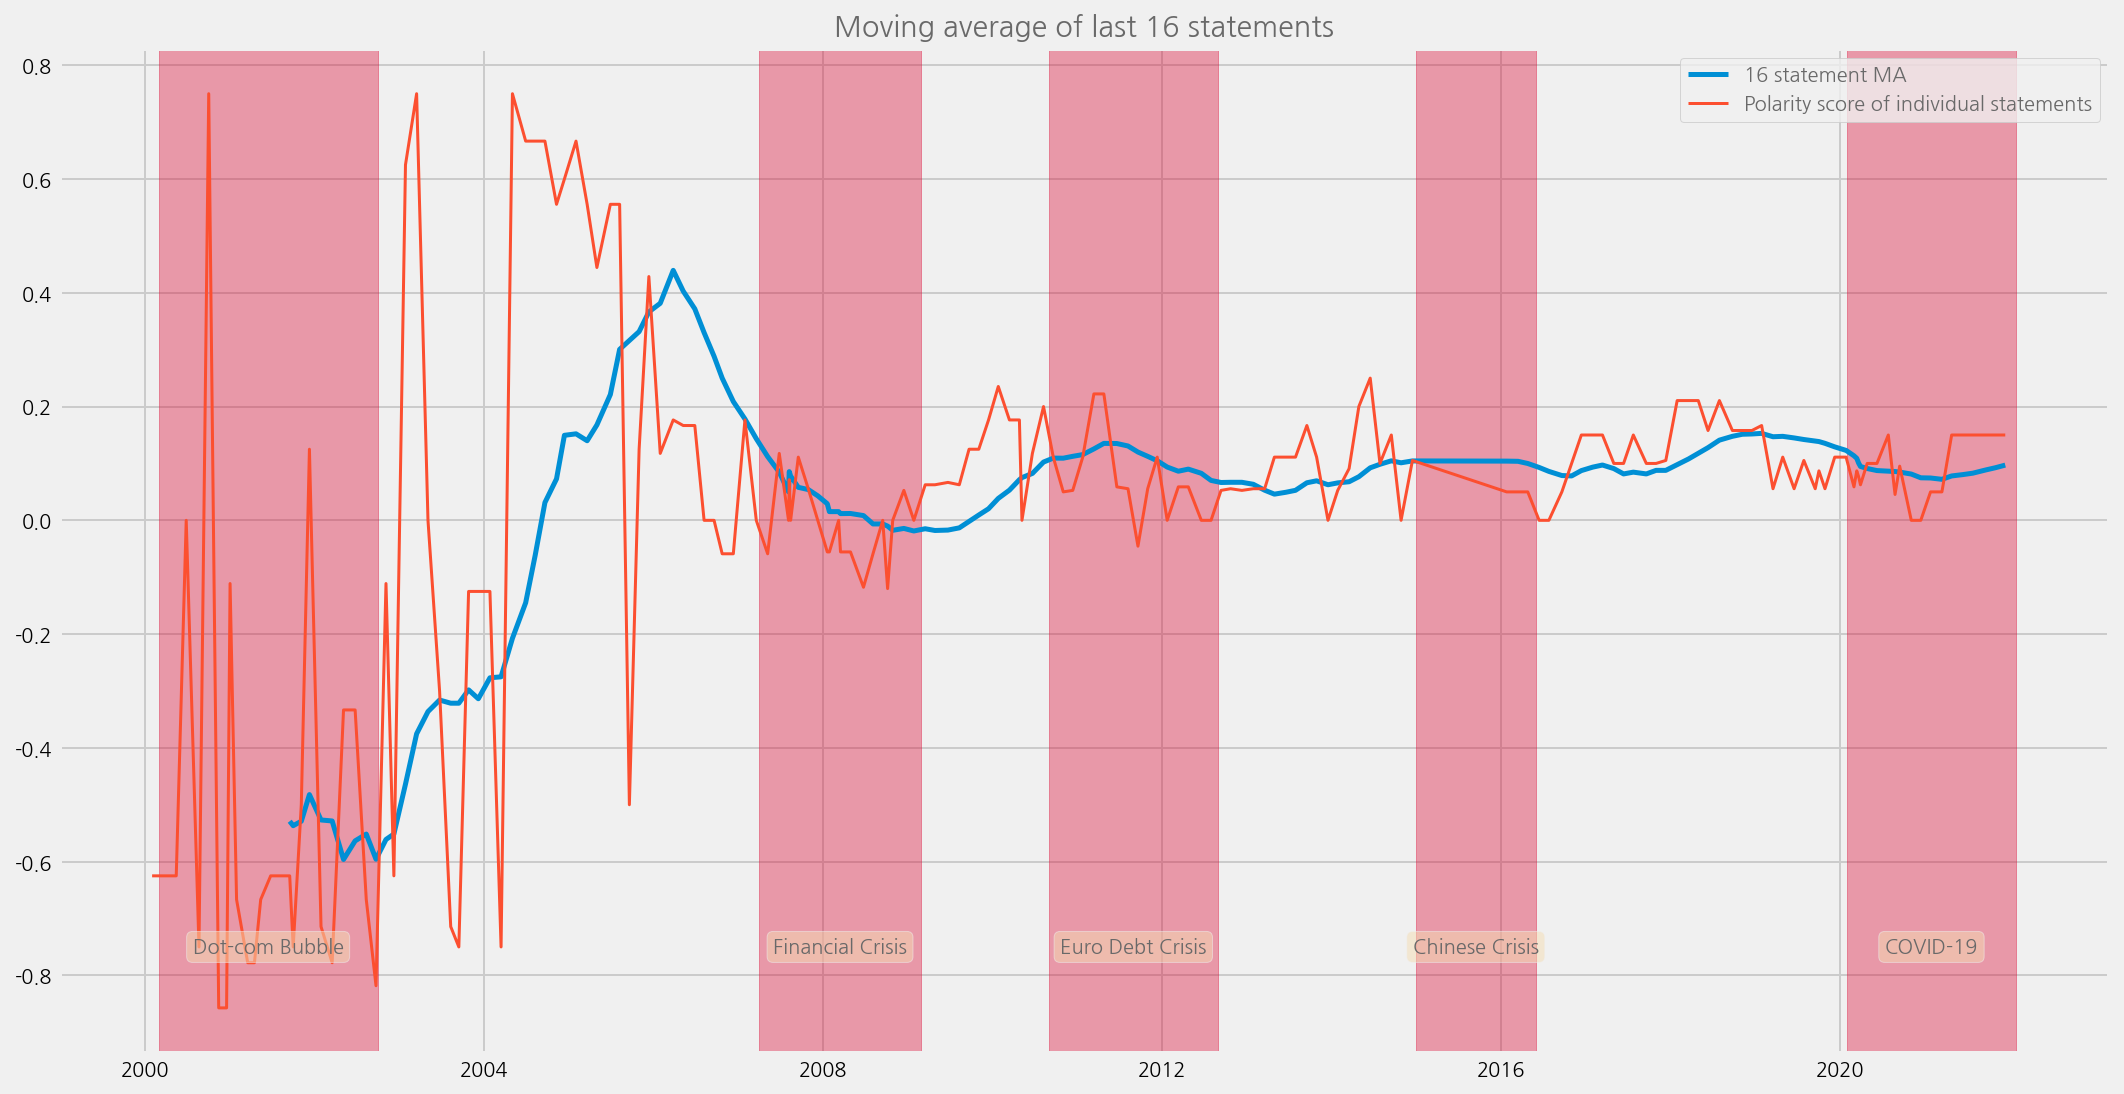

In [19]:
window = 16
fomc_sentiments["polarity_ma"] = fomc_sentiments.polarity_diffusion.rolling(window).mean()

cfg = eKonf.compose("visualize/plot=lineplot")
cfg.figure.figsize = (15, 8)
cfg.plot.x = "timestamp"
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].linewidth = 2.5
cfg.plots[0].palette = "r"
cfg.plots[1].y = "polarity_diffusion"
cfg.plots[1].linewidth = 1.5
cfg.plots[1].palette = "g"
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend.labels = [
    f"{window} statement MA",
    "Polarity score of individual statements",
]
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations
eKonf.instantiate(cfg, data=fomc_sentiments)

In [20]:
from datetime import datetime

chair = fomc.chairpersons
chair = chair[chair.to_date.dt.year >= start_year]
annot_args = eKonf.compose("visualize/plot/ax/annotation")

spans = []
annotations = []
for row in chair.iterrows():
    row_num = row[0]
    start = row[1]["from_date"]
    if start.year < 2000:
        start = datetime(2000, 1, 1)
    end = row[1]["to_date"]
    annotation = row[1]["last_name"]
    color = "crimson" if row_num % 2 == 0 else "darkblue"
    alpha = 0.4 if row_num % 2 == 0 else 0.0
    span = {
        "xmin": eKonf.to_dateparm(start),
        "xmax": eKonf.to_dateparm(end),
        "alpha": alpha,
        "color": color,
    }

    x = start + (end - start) / 2
    y = -0.75
    annot = annot_args.copy()
    annot.text, annot.x, annot.y = annotation, eKonf.to_dateparm(x), y

    spans.append(span)
    annotations.append(annot)


INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'red', 'x': 'timestamp', 'y': 'polarity_ma', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ekorpkit.visualize.plot:Plotting lineplot with {'linewidth': 2, 'color': 'green', 'x': 'timestamp', 'y': 'polarity_diffusion', 'palette': None, 'hue': None, 'size': None, 'style': None, 'hue_order': None, 'hue_norm': None, 'sizes': None, 'size_order': None, 'size_norm': None, 'dashes': True, 'markers': None, 'style_order': None, 'units': None, 'estimator': 'mean', 'ci': 95, 'n_boot': 1000, 'seed': None, 'sort': True, 'err_style': 'band', 'err_kws': None, 'legend': 'auto', 'drawstyle': None}
INFO:ek

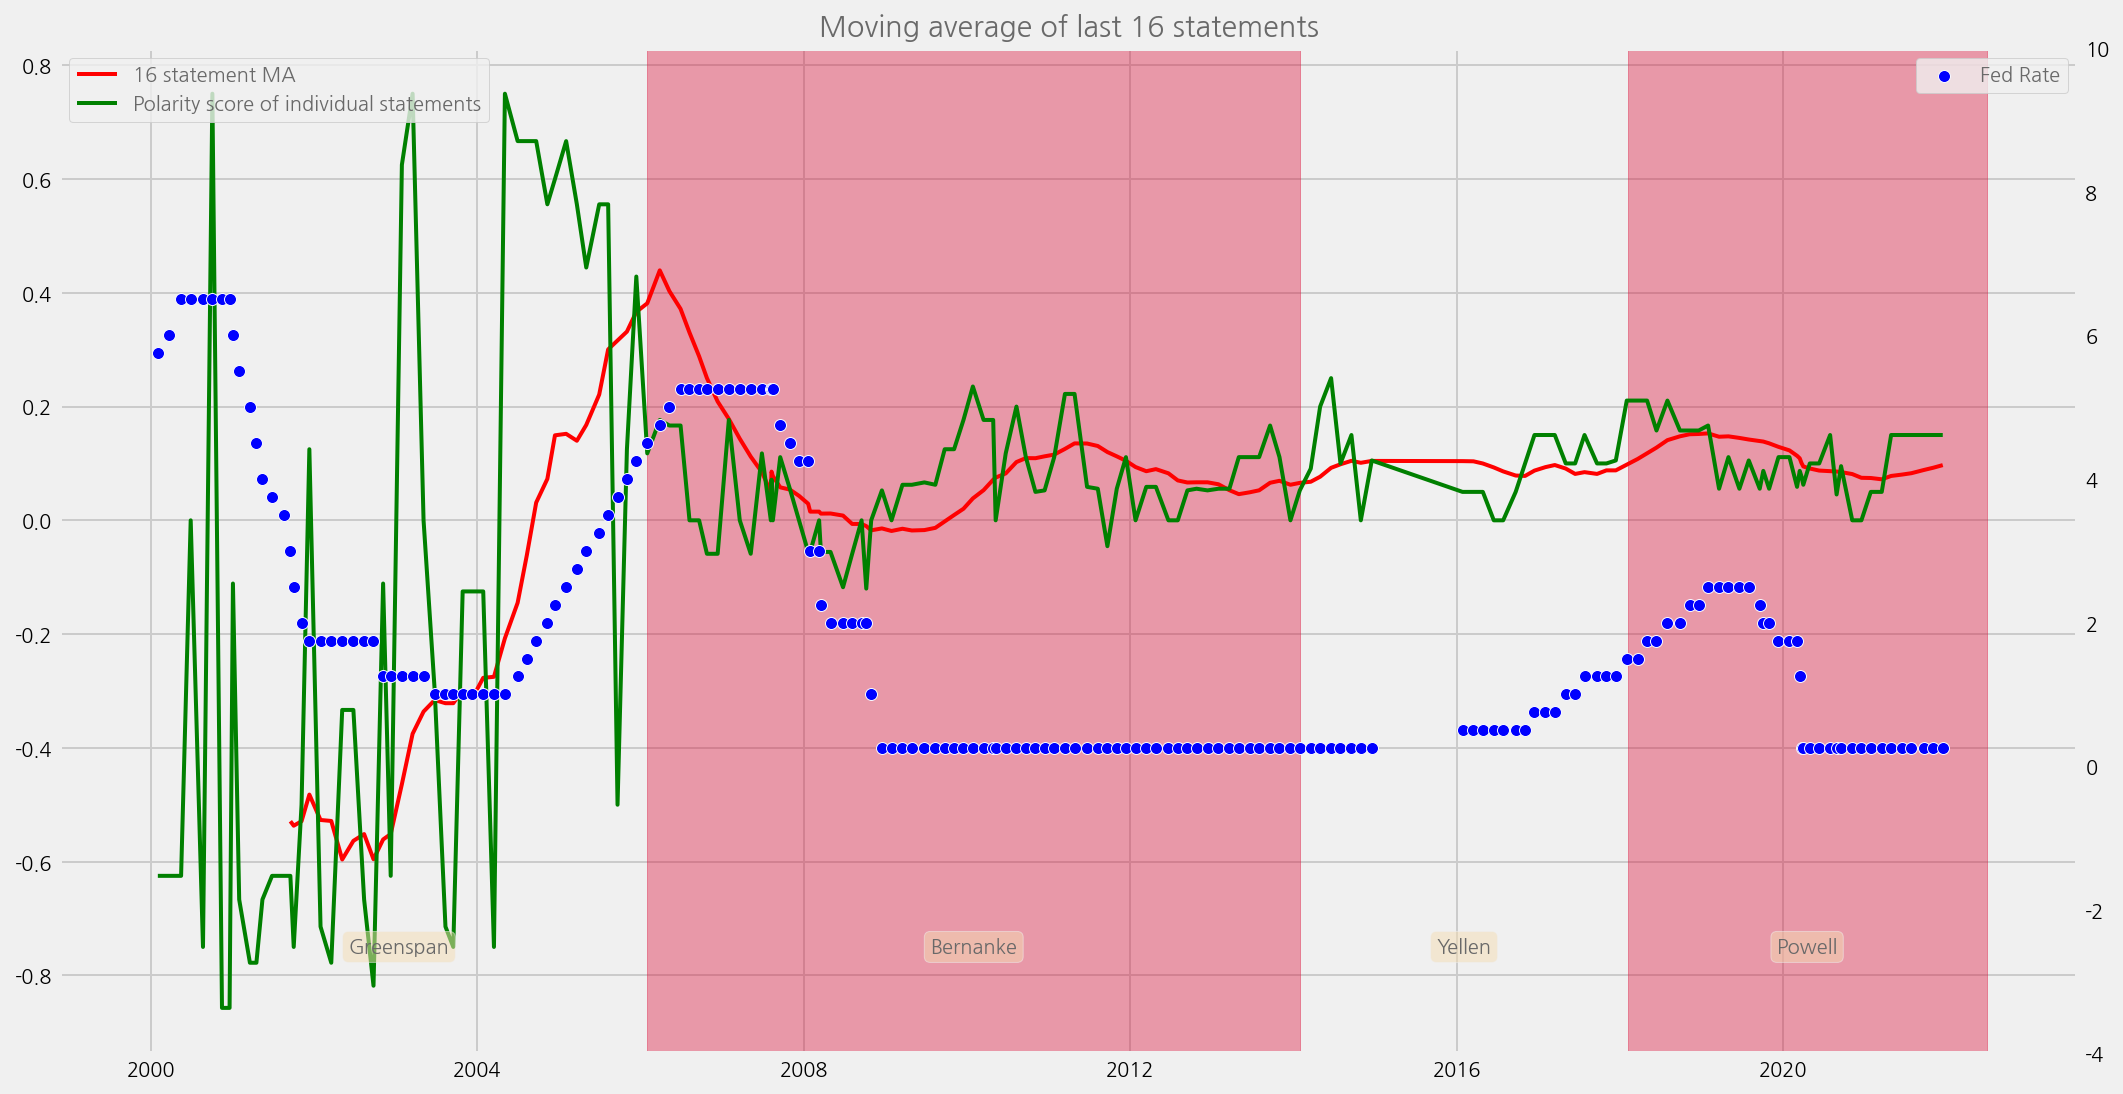

In [22]:
cfg = eKonf.compose("visualize/plot=lineplot")
cfg.plot.x = "timestamp"
ax2 = cfg.ax.copy()

cfg.figure.figsize = (15, 8)
cfg.plots.append(cfg.plot.copy())
cfg.plots[0].y = "polarity_ma"
cfg.plots[0].rcParams = dict(linewidth=2.5, color="red")
cfg.plots[1].y = "polarity_diffusion"
cfg.plots[1].rcParams = dict(linewidth=1.5, color="green")
cfg.ax.title = f"Moving average of last {window} statements"
cfg.ax.legend = dict(
    labels=[
        f"{window} statement MA",
        "Polarity score of individual statements",
    ],
    loc=2,
)
scatter_cfg = eKonf.compose("visualize/plot/scatterplot")
scatter_cfg.y = "DFEDTAR"
scatter_cfg.secondary_y = True
scatter_cfg.rcParams = dict(color="blue", alpha=0.8)
cfg.plots.append(scatter_cfg)

ax2.grid = False
ax2.secondary_y = True
ax2.ylim = "(-4, 10)"
ax2.legend = dict(
    labels=["Fed Rate"],
    loc=1,
)
cfg.axes.append(ax2)
cfg.ax.axvspans = spans
cfg.ax.annotations = annotations

eKonf.instantiate(cfg, data=fomc_sentiments)
